In [49]:
## import csv
import numpy as np
import os
import pandas as pd
import warnings
from tqdm import tqdm

from keras import callbacks
from keras import layers
from keras import models
from keras import Sequential
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

np.random.seed = 42
warnings.filterwarnings("ignore")

In [22]:
candidates = pd.read_csv('./data/candidate_items.csv')
candidates

item_id
0           4
1           8
2           9
3          19
4          20
...       ...
4985    28128
4986    28131
4987    28132
4988    28133
4989    28137

[4990 rows x 1 columns]

In [23]:
items = pd.read_csv('./data/item_features.csv')
items

item_id  feature_category_id  feature_value_id
0             2                   56               365
1             2                   62               801
2             2                   68               351
3             2                   33               802
4             2                   72                75
...         ...                  ...               ...
471746    28143                   68               351
471747    28143                   55               390
471748    28143                   11               109
471749    28143                   73                91
471750    28143                   47               549

[471751 rows x 3 columns]

In [24]:
train_purchases = pd.read_csv('./data/train_purchases.csv', parse_dates=[2])
train_purchases

session_id  item_id                    date
0                3    15085 2020-12-18 21:26:47.986
1               13    18626 2020-03-13 19:36:15.507
2               18    24911 2020-08-26 19:20:32.049
3               19    12534 2020-11-02 17:16:45.920
4               24    13226 2020-02-26 18:27:44.114
...            ...      ...                     ...
999995     4439986     2915 2021-05-13 11:56:37.464
999996     4439990     8786 2020-08-22 14:28:22.382
999997     4439994    21630 2020-11-27 20:10:28.961
999998     4439999    16962 2020-11-27 11:01:41.356
999999     4440001    16631 2020-10-30 23:46:05.218

[1000000 rows x 3 columns]

In [25]:
train_sessions = pd.read_csv('./data/train_sessions.csv', parse_dates=[2])
train_sessions

session_id  item_id                    date
0                 3     9655 2020-12-18 21:25:00.373
1                 3     9655 2020-12-18 21:19:48.093
2                13    15654 2020-03-13 19:35:27.136
3                18    18316 2020-08-26 19:18:30.833
4                18     2507 2020-08-26 19:16:31.211
...             ...      ...                     ...
4743815     4440001    20409 2020-10-30 23:37:20.658
4743816     4440001    14155 2020-10-30 23:31:56.607
4743817     4440001    14303 2020-10-30 23:36:17.934
4743818     4440001    27852 2020-10-30 23:39:55.186
4743819     4440001      305 2020-10-30 23:27:37.873

[4743820 rows x 3 columns]

In [26]:
test_leaderboard_sessions = pd.read_csv('./data/test_leaderboard_sessions.csv', parse_dates=[2])
test_leaderboard_sessions

session_id  item_id                    date
0               26    19185 2021-06-16 09:53:54.158
1              200    17089 2021-06-25 12:23:40.811
2              200    17089 2021-06-25 12:24:36.631
3              200     8060 2021-06-25 12:24:41.677
4              200     4758 2021-06-25 12:24:50.692
...            ...      ...                     ...
229349     4439653    25955 2021-06-11 10:22:57.470
229350     4439653    12179 2021-06-11 10:23:00.663
229351     4439757     2078 2021-06-30 11:42:15.073
229352     4439757     2078 2021-06-30 11:43:13.725
229353     4439757     6790 2021-06-30 11:44:52.704

[229354 rows x 3 columns]

# Embedding items
Items are represented in a sparse format with the id of the feature and its value. We have no information on whether or not it is categorical or numerical, or the number of features. We want to explore them a little bit and find a compact representation.

First we want to know the coverage of each feature. Do a plot with, in x-axis, the feature id, and in y-axis, the number of non-null values.

<AxesSubplot:title={'center':'Count of non-null values per feature category'}, xlabel='Feature Category ID', ylabel='Non-null values count'>

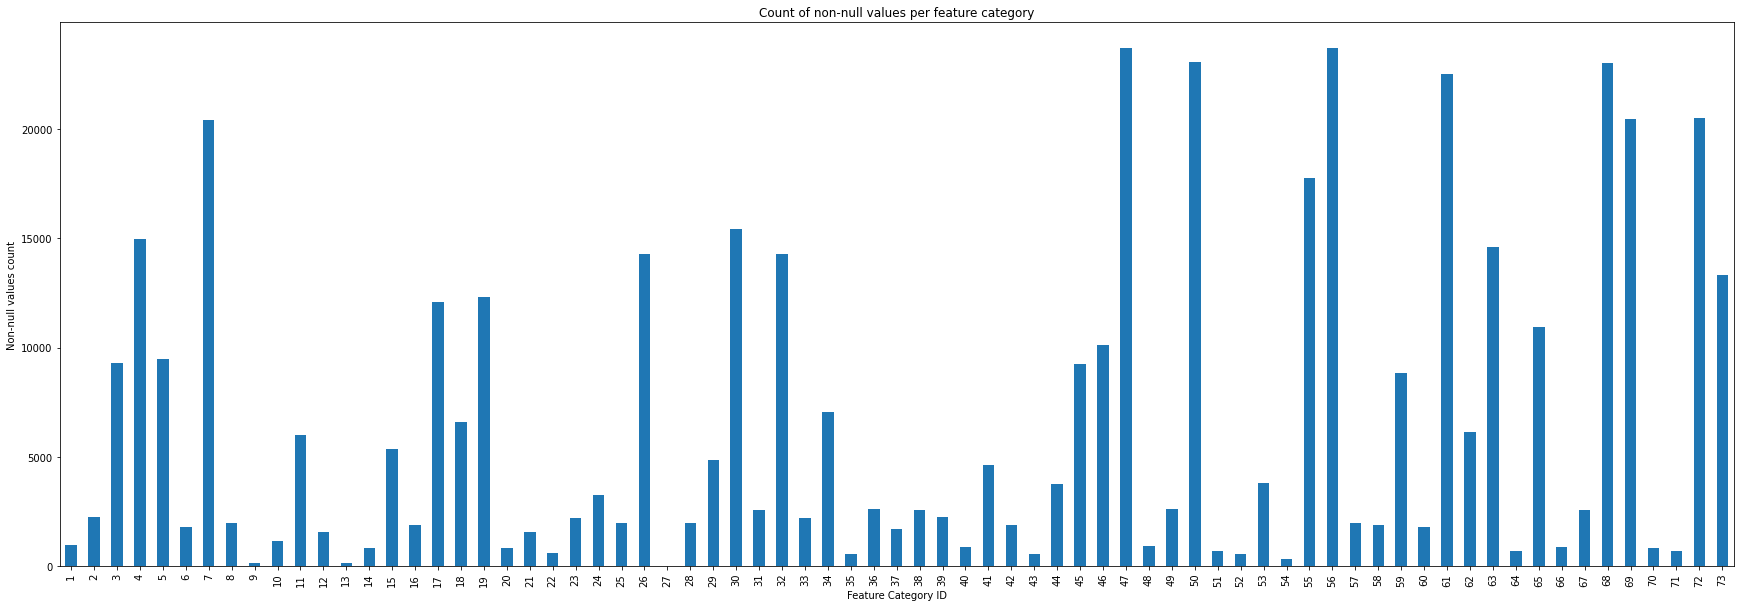

In [27]:
items.groupby('feature_category_id').count().drop('item_id',axis=1).plot(
    kind='bar',
    legend=False,
    figsize=(30, 10),
    xlabel='Feature Category ID',
    ylabel='Non-null values count',
    title='Count of non-null values per feature category'
)

73 features is not that much, let's see how each of them look. Display the counts / min / max / std for each feature. You should see that one feature is useless, remove it!

In [28]:
items.groupby('feature_category_id')['feature_value_id'].describe().sort_values(by='count')

count        mean         std    min    25%    50%  \
feature_category_id                                                         
27                       1.0  423.000000         NaN  423.0  423.0  423.0   
9                      137.0  223.635036   77.537171  175.0  175.0  190.0   
13                     137.0  580.554745  206.876701  252.0  252.0  698.0   
54                     341.0  760.448680  101.582889  197.0  785.0  785.0   
52                     568.0  551.839789  223.219225  227.0  293.0  728.0   
...                      ...         ...         ...    ...    ...    ...   
61                   22512.0  676.885528  154.116169   59.0  706.0  706.0   
68                   23038.0  443.496050  230.800434   10.0  351.0  373.0   
50                   23077.0  483.046757  285.430458    8.0  240.0  328.0   
47                   23691.0  381.648136  262.024894   36.0  123.0  516.0   
56                   23691.0  360.189861  107.438375    1.0  365.0  365.0   

                       75%    max  
feature_category_id                
27                   423.0  423.0  
9                    190.0  369.0  
13                   698.0  905.0  
54                   785.0  785.0  
52                   756.0  756.0  
...                    ...    ...  
61                   706.0  898.0  
68                   702.0  903.0  
50                   708.0  901.0  
47                   549.0  884.0  
56                   365.0  868.0  

[73 rows x 8 columns]

In [29]:
items = items.drop(items[items.feature_category_id == 27].index)
items

item_id  feature_category_id  feature_value_id
0             2                   56               365
1             2                   62               801
2             2                   68               351
3             2                   33               802
4             2                   72                75
...         ...                  ...               ...
471746    28143                   68               351
471747    28143                   55               390
471748    28143                   11               109
471749    28143                   73                91
471750    28143                   47               549

[471750 rows x 3 columns]

If 73 features is not a lot, it is still a big number given the number of samples for your poor laptop if you make it dense. It is also good practice to preprocess the data into a set of embeddings without sparse format because most ML algorithm do not handle sparse. We want to do it now. Use TruncatedSVD from scikit-learn with n_components = 12 (or less depending on your memory) and compute embeddings for your items.

In [30]:
matrix = sparse.coo_matrix((items["feature_value_id"], (items["item_id"], items["feature_category_id"])))
matrix

<28144x74 sparse matrix of type '<class 'numpy.int64'>'
	with 471750 stored elements in COOrdinate format>

In [31]:
svd = TruncatedSVD(n_components=12)
embeddings = pd.DataFrame(svd.fit_transform(matrix))
embeddings.shape

(28144, 12)

You now have a matrix of dimension (28144, n_components) representing the items.

In [32]:
embeddings

0           1            2           3            4   \
0         0.000000    0.000000     0.000000    0.000000     0.000000   
1         0.000000    0.000000     0.000000    0.000000     0.000000   
2       794.680184  377.343645  -303.561676  669.612878   487.114992   
3      2387.218101 -924.921011   161.342836 -448.550059   -36.610575   
4      2304.639154 -837.402436   194.342671 -143.934264  -183.789060   
...            ...         ...          ...         ...          ...   
28139  2496.719059 -681.709968   127.865506   94.363969  -141.323815   
28140   747.063373  532.023458 -1458.557335 -589.887948  -396.120679   
28141  2039.201872 -664.322600    27.056820 -712.698197    16.569613   
28142  1472.569195  356.499022  -347.940107   38.524876   879.686380   
28143  1416.456714  285.630602  -353.123112 -233.109351  1079.420598   

               5           6           7           8           9           10  \
0        0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
1        0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
2       31.146902  179.064754  297.251224 -153.140777 -448.271076  -82.041573   
3     -508.694910 -261.145625  140.767976 -136.239831  -87.366252  103.304190   
4        3.296696  190.618123 -170.615097 -157.486120  -62.954388 -372.439320   
...           ...         ...         ...         ...         ...         ...   
28139  830.505840 -244.846740  -96.655286  367.493760   37.535376 -406.521269   
28140    6.419096   44.149717  -82.303548 -222.587349 -185.587341   81.843742   
28141   17.025563  252.163658 -164.763142  -57.624989 -300.177599  -73.188789   
28142  493.893405   56.289931   12.025247  226.942864  -35.454629 -238.424179   
28143   34.144437 -404.375991  -79.810749 -130.878739  199.023523  -31.212301   

               11  
0        0.000000  
1        0.000000  
2       45.718381  
3     -517.273680  
4       54.728212  
...           ...  
28139  -30.963681  
28140  -79.027145  
28141 -139.437054  
28142 -303.152925  
28143  372.492276  

[28144 rows x 12 columns]

In [33]:
del items
del matrix
del svd

# Embedding sessions

Sessions are defined by a series of items, we first want to see what they look like to be able to find a suitable representation for them.

My advice: start by sampling the train_sessions dataframe to keep 5% or 10% otherwise your memory may suffer.

Then plot the distribution of session sizes: x-axis is the size of the session, y-axis is the number of sessions of this size. Determine a threshold to contain completely 90% of the sessions. This is how we will compute the session representation.

session_id  item_id                    date  rank
4727843     4424589    12585 2020-08-31 14:17:47.728     4
36329         34375    25415 2021-05-27 15:03:49.149     1
2167023     2026971    10804 2020-01-15 08:16:40.485     1
4130549     3863628     6660 2021-01-18 16:25:37.330     1
3311258     3096457    27555 2021-02-10 09:49:38.869     1
...             ...      ...                     ...   ...
1265468     1185638    15403 2021-04-20 16:56:55.198     1
1514501     1417027     3683 2021-05-29 09:57:46.759     1
2759531     2576090     1786 2020-07-26 07:14:53.643     1
623693       583606     9238 2020-04-22 16:34:43.783     2
770640       721431    24818 2020-02-08 13:53:43.790     1

[474382 rows x 4 columns]

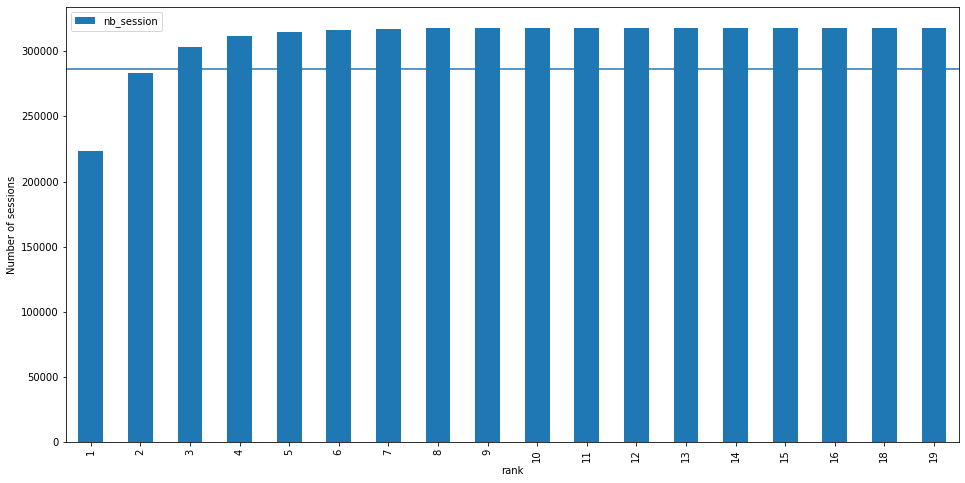

In [34]:
sample_size = int(len(train_sessions) * 0.1)
sample = train_sessions.sample(sample_size)

session_infos = sample.groupby('session_id').agg(rank=('item_id', 'count'))
session_infos['session_id'] = session_infos.index

plot_session = session_infos.groupby('rank').agg(nb_session=('session_id', 'count'))
plot_session['nb_session'] = plot_session["nb_session"].cumsum()

ax = plot_session.plot(kind='bar', figsize=(16, 8))
ax.axhline(y=plot_session['nb_session'].max() * 0.9)
ax.set_ylabel('Number of sessions')

sample = sample.join(session_infos, on='session_id', rsuffix='_outer').drop('session_id_outer', axis=1)
sample

Let $k$ be the length you have picked for your session. Create a vectorize representation of your sessions by either concatenating the embedding of the corresponding items, or averaging them (if memory is scarse).

In [35]:
k = 4
sample = sample[sample['rank'] < k]
sample

session_id  item_id                    date  rank
36329         34375    25415 2021-05-27 15:03:49.149     1
2167023     2026971    10804 2020-01-15 08:16:40.485     1
4130549     3863628     6660 2021-01-18 16:25:37.330     1
3311258     3096457    27555 2021-02-10 09:49:38.869     1
3163773     2957349     6534 2020-10-23 12:08:00.336     1
...             ...      ...                     ...   ...
1265468     1185638    15403 2021-04-20 16:56:55.198     1
1514501     1417027     3683 2021-05-29 09:57:46.759     1
2759531     2576090     1786 2020-07-26 07:14:53.643     1
623693       583606     9238 2020-04-22 16:34:43.783     2
770640       721431    24818 2020-02-08 13:53:43.790     1

[403563 rows x 4 columns]

In [36]:
def get_x_feature(serie, n):
    if len(serie) <= n:
        return 0.
    return serie.iloc[n]

sample = sample.drop(['date', 'rank'], axis=1) \
               .join(embeddings, on='item_id', rsuffix='_outer') \
               .set_index('session_id')

columns = { f'<lambda_{i}>': i + 1 for i in range(10) }

sample = sample.groupby('session_id')[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11].agg([
    lambda x: get_x_feature(x, 0),
    lambda x: get_x_feature(x, 1),
    lambda x: get_x_feature(x, 2),
    lambda x: get_x_feature(x, 3),
    lambda x: get_x_feature(x, 4),
    lambda x: get_x_feature(x, 5),
    lambda x: get_x_feature(x, 6),
    lambda x: get_x_feature(x, 7),
    lambda x: get_x_feature(x, 8),
    lambda x: get_x_feature(x, 9),
]).rename(columns=columns)

sample.columns = sample.columns.to_flat_index()
sample

(0, 1)       (0, 2)  (0, 3)  (0, 4)  (0, 5)  (0, 6)  (0, 7)  \
session_id                                                                     
19          2118.783827  2116.066633     0.0     0.0     0.0     0.0     0.0   
24          1472.880675     0.000000     0.0     0.0     0.0     0.0     0.0   
36          1121.288268     0.000000     0.0     0.0     0.0     0.0     0.0   
115          855.282366     0.000000     0.0     0.0     0.0     0.0     0.0   
119         1381.851224     0.000000     0.0     0.0     0.0     0.0     0.0   
...                 ...          ...     ...     ...     ...     ...     ...   
4439982     1880.247264     0.000000     0.0     0.0     0.0     0.0     0.0   
4439986     1492.471577     0.000000     0.0     0.0     0.0     0.0     0.0   
4439994     1951.515892     0.000000     0.0     0.0     0.0     0.0     0.0   
4439999     2563.672340  2110.649809     0.0     0.0     0.0     0.0     0.0   
4440001     1558.079274     0.000000     0.0     0.0     0.0     0.0     0.0   

            (0, 8)  (0, 9)  (0, 10)  ...     (11, 1)     (11, 2)  (11, 3)  \
session_id                           ...                                    
19             0.0     0.0      0.0  ... -144.459695 -174.019170      0.0   
24             0.0     0.0      0.0  ...  -59.348660    0.000000      0.0   
36             0.0     0.0      0.0  ...  -37.159639    0.000000      0.0   
115            0.0     0.0      0.0  ...  -72.784527    0.000000      0.0   
119            0.0     0.0      0.0  ...  166.356213    0.000000      0.0   
...            ...     ...      ...  ...         ...         ...      ...   
4439982        0.0     0.0      0.0  ... -194.541243    0.000000      0.0   
4439986        0.0     0.0      0.0  ...  243.601772    0.000000      0.0   
4439994        0.0     0.0      0.0  ... -203.147134    0.000000      0.0   
4439999        0.0     0.0      0.0  ...   24.462350   21.763902      0.0   
4440001        0.0     0.0      0.0  ...  232.505258    0.000000      0.0   

            (11, 4)  (11, 5)  (11, 6)  (11, 7)  (11, 8)  (11, 9)  (11, 10)  
session_id                                                                  
19              0.0      0.0      0.0      0.0      0.0      0.0       0.0  
24              0.0      0.0      0.0      0.0      0.0      0.0       0.0  
36              0.0      0.0      0.0      0.0      0.0      0.0       0.0  
115             0.0      0.0      0.0      0.0      0.0      0.0       0.0  
119             0.0      0.0      0.0      0.0      0.0      0.0       0.0  
...             ...      ...      ...      ...      ...      ...       ...  
4439982         0.0      0.0      0.0      0.0      0.0      0.0       0.0  
4439986         0.0      0.0      0.0      0.0      0.0      0.0       0.0  
4439994         0.0      0.0      0.0      0.0      0.0      0.0       0.0  
4439999         0.0      0.0      0.0      0.0      0.0      0.0       0.0  
4440001         0.0      0.0      0.0      0.0      0.0      0.0       0.0  

[303532 rows x 120 columns]

In [37]:
del session_infos, plot_session

# Embedding purchases
Purchases are one item, so we simply use their embedding. However, we also need to add negative samples so that our model not only learn on positives (One class SVM can do this, but those models are not known to generalize well...). In order to generate negative samples, shuffle the item_id columns of 4 copies of the purchase array. The original values have a label 1, the copies that have been shuffled have a value of 0.

In [38]:
negative_train_purchases = pd.concat([train_purchases.copy() for x in range(4)]).sample(frac=1).reset_index(drop=True)
negative_train_purchases['item_id'] = np.random.permutation(negative_train_purchases['item_id'])
negative_train_purchases['y'] = 0

all_purchases = train_purchases.copy()
all_purchases['y'] = 1

all_purchases = pd.concat([all_purchases, negative_train_purchases]).drop('date', axis=1).reset_index(drop=True)
all_purchases = embeddings.merge(all_purchases, right_on='item_id', left_index=True).drop('item_id', axis=1)
all_purchases

0           1           2           3            4  \
38061    2387.218101 -924.921011  161.342836 -448.550059   -36.610575   
41931    2387.218101 -924.921011  161.342836 -448.550059   -36.610575   
89368    2387.218101 -924.921011  161.342836 -448.550059   -36.610575   
181165   2387.218101 -924.921011  161.342836 -448.550059   -36.610575   
213634   2387.218101 -924.921011  161.342836 -448.550059   -36.610575   
...              ...         ...         ...         ...          ...   
3815095  1416.456714  285.630602 -353.123112 -233.109351  1079.420598   
4397994  1416.456714  285.630602 -353.123112 -233.109351  1079.420598   
4575884  1416.456714  285.630602 -353.123112 -233.109351  1079.420598   
4626807  1416.456714  285.630602 -353.123112 -233.109351  1079.420598   
4709493  1416.456714  285.630602 -353.123112 -233.109351  1079.420598   

                  5           6           7           8           9  \
38061   -508.694910 -261.145625  140.767976 -136.239831  -87.366252   
41931   -508.694910 -261.145625  140.767976 -136.239831  -87.366252   
89368   -508.694910 -261.145625  140.767976 -136.239831  -87.366252   
181165  -508.694910 -261.145625  140.767976 -136.239831  -87.366252   
213634  -508.694910 -261.145625  140.767976 -136.239831  -87.366252   
...             ...         ...         ...         ...         ...   
3815095   34.144437 -404.375991  -79.810749 -130.878739  199.023523   
4397994   34.144437 -404.375991  -79.810749 -130.878739  199.023523   
4575884   34.144437 -404.375991  -79.810749 -130.878739  199.023523   
4626807   34.144437 -404.375991  -79.810749 -130.878739  199.023523   
4709493   34.144437 -404.375991  -79.810749 -130.878739  199.023523   

                 10          11  session_id  y  
38061    103.304190 -517.273680      169632  1  
41931    103.304190 -517.273680      186292  1  
89368    103.304190 -517.273680      399081  1  
181165   103.304190 -517.273680      807144  1  
213634   103.304190 -517.273680      951781  1  
...             ...         ...         ... ..  
3815095  -31.212301  372.492276      216106  0  
4397994  -31.212301  372.492276      253636  0  
4575884  -31.212301  372.492276     4438226  0  
4626807  -31.212301  372.492276      213585  0  
4709493  -31.212301  372.492276      269812  0  

[5000000 rows x 14 columns]

In [39]:
del train_purchases, negative_train_purchases

# Merge everything

We merge the whole dataset together to fit a model. For each session we concatenate:
* The history of the user
* The purchase embedding, with the label

We will have our training set!

In [40]:
data = sample.merge(all_purchases, how='inner', on='session_id')
data.head(12)

session_id       (0, 1)       (0, 2)  (0, 3)  (0, 4)  (0, 5)  (0, 6)  \
0           19  2118.783827  2116.066633     0.0     0.0     0.0     0.0   
1           19  2118.783827  2116.066633     0.0     0.0     0.0     0.0   
2           19  2118.783827  2116.066633     0.0     0.0     0.0     0.0   
3           19  2118.783827  2116.066633     0.0     0.0     0.0     0.0   
4           19  2118.783827  2116.066633     0.0     0.0     0.0     0.0   
5           24  1472.880675     0.000000     0.0     0.0     0.0     0.0   
6           24  1472.880675     0.000000     0.0     0.0     0.0     0.0   
7           24  1472.880675     0.000000     0.0     0.0     0.0     0.0   
8           24  1472.880675     0.000000     0.0     0.0     0.0     0.0   
9           24  1472.880675     0.000000     0.0     0.0     0.0     0.0   
10          36  1121.288268     0.000000     0.0     0.0     0.0     0.0   
11          36  1121.288268     0.000000     0.0     0.0     0.0     0.0   

    (0, 7)  (0, 8)  (0, 9)  ...            3           4           5  \
0      0.0     0.0     0.0  ...  -348.270845  -78.353777 -229.324141   
1      0.0     0.0     0.0  ...   215.296807 -432.500637  827.456155   
2      0.0     0.0     0.0  ...  -307.917325 -111.158758 -477.787660   
3      0.0     0.0     0.0  ...  -374.863772  306.686357    1.165747   
4      0.0     0.0     0.0  ...  1240.519616 -137.946987 -471.464171   
5      0.0     0.0     0.0  ...  -358.796235 -293.438881 -263.310812   
6      0.0     0.0     0.0  ...  -361.537813  299.251828 -301.193329   
7      0.0     0.0     0.0  ...  1222.546352  175.505305 -190.713418   
8      0.0     0.0     0.0  ...    29.399966 -215.720696  681.448523   
9      0.0     0.0     0.0  ...  -515.410791 -353.402277  -63.781118   
10     0.0     0.0     0.0  ...  -224.956040 -152.482074 -288.179584   
11     0.0     0.0     0.0  ...  -361.201382  -55.852412 -603.688084   

              6           7           8           9          10          11  y  
0   1100.605491  503.219577  411.445509  193.360985 -142.846823  247.893072  0  
1    -84.612864   85.697165  320.960760  310.850785  -27.615089  -41.499050  0  
2   -236.804349  546.875946  560.332460   69.480537   83.676767 -175.148642  0  
3    263.789906 -383.403369 -294.941503 -158.983470 -320.950925  358.758966  1  
4     13.560585 -594.915127 -267.599254  205.540073  -89.544626  -85.094028  0  
5    932.907535   17.393183  -68.369373  -56.294388   45.831226 -242.360545  0  
6   -747.334867  254.454787  246.046868  185.640466   37.912982  143.896854  0  
7    122.737134   24.286334  613.985706  -57.261460   76.990997  262.348330  1  
8   -258.665697 -267.796572  292.530147  240.912420 -225.144857  215.306511  0  
9     49.829532  -78.279822 -190.355846 -154.071008   38.310303  -18.826107  0  
10  -120.718771  168.682655  -69.453466  -73.677287   26.654722 -400.284632  0  
11  -377.832496  436.872161  227.007890  119.773848 -379.337228  220.195011  0  

[12 rows x 134 columns]

In [41]:
del all_purchases

# Learn a model and predict on test

This is it. You have now a dataset that you can directly pass to a LogisticRegression. For the testing part, perform your prediction on all candidates and pick the hundred ones that have the highest results.

In [42]:
model = LogisticRegression()

X, y = data.copy().drop(['y', 'session_id'], axis=1), data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y)

model.fit(X, y)
model.score(X_test, y_test)


0.8009778211193548

In [43]:
empty_model_input = X_test.copy()[0:0]
del data
del X, y
del sample, train_sessions

In [44]:
def get_model_input(history):
    items_embedded = empty_model_input.copy()
    items_embedded.loc[0] = 0.0

    for i in range(len(history)):
        items_embedded.at[0, [(j, i + 1) for j in range(12)]] = embeddings.iloc[history[i]].values

    return items_embedded

In [45]:
def predict_best_100(history):
    assert len(history) < k

    model_input = get_model_input(history)

    items_proba = []
    for candidate in candidates['item_id']:
        model_input.at[0, [i for i in range(12)]] = embeddings.iloc[candidate]
        candidate_proba = model.predict_proba(model_input)[0][0]
        items_proba.append((candidate, candidate_proba))

    items_proba.sort(key=lambda x : -x[1])
    
    best_without_history = filter(lambda x : not (x[0] in history), items_proba)
    return list(map(lambda x : x[0], best_without_history))[:100]


In [46]:
print(predict_best_100([2, 4, 16]))

[2222, 11006, 24067, 17454, 22931, 22441, 20165, 22178, 14192, 24881, 8178, 22146, 3440, 5377, 7244, 12127, 20437, 15087, 25118, 2429, 9564, 13273, 2256, 2967, 2831, 603, 5233, 24123, 19458, 26622, 13973, 21919, 13250, 16631, 11328, 23286, 24005, 720, 17065, 16045, 19099, 19115, 11515, 1968, 3298, 3019, 222, 2998, 12179, 9562, 19987, 9411, 23889, 27974, 175, 27754, 21185, 5288, 652, 16776, 10496, 808, 10625, 16139, 27800, 18809, 24814, 25184, 21241, 14214, 19297, 21313, 25083, 18626, 9915, 27702, 4113, 18183, 10980, 18061, 19955, 21116, 21998, 1036, 11689, 26985, 502, 15246, 398, 13717, 16145, 27183, 14240, 25566, 8981, 27731, 12282, 17057, 1784, 2103]


### LeaderBoard

In [50]:
def compute_full_leaderboard(file, predict_function):

    if os.path.exists(file):
        os.remove(file)

    with open(file, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['session_id', 'item_id', 'rank'])

        for session in tqdm(test_leaderboard_sessions.session_id.unique()):
            item_ids = test_leaderboard_sessions[test_leaderboard_sessions.session_id == session]['item_id'].to_list()
            bests = predict_function(item_ids[:k-1])
            rows = [(session, item_id, i + 1) for i, item_id in enumerate(bests)]
            writer.writerows(rows)

In [51]:
compute_full_leaderboard('submission.csv', predict_best_100)

  0%|                                                                                                                                                                          | 5/50000 [00:37<103:05:02,  7.42s/it]


KeyboardInterrupt: 

# Going further

Your next task is to have an RNN running on this dataset. Take a look at [this notebook](https://github.com/oakfr/intro-to-reco/blob/master/application/part_2/RNN-next-item-prediction.ipynb) and adapt it to your usecase!

You are now ready to start the project. Take a look at the packages [surprise](http://surpriselib.com/) and [Microsoft recommenders](https://github.com/microsoft/recommenders) to find models available out of the box.

In [68]:
model = Sequential()

model.add(layers.Masking(mask_value = 0, input_shape = (11, 12)))
model.add(layers.LSTM(50, return_sequences=True))
model.add(layers.LSTM(100,return_sequences=False))
model.add(layers.Dense(2, activation='softmax'))

model.compile("adam", loss="sparse_categorical_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, 11, 12)            0         
                                                                 
 lstm_4 (LSTM)               (None, 11, 50)            12600     
                                                                 
 lstm_5 (LSTM)               (None, 100)               60400     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 73,202
Trainable params: 73,202
Non-trainable params: 0
_________________________________________________________________


In [69]:
def reshape_data(X) :
    df = X.reindex(columns = 
    pd.Index([
        (0,1),(1,1),(2,1),(3,1),(4,1),(5,1),(6,1),(7,1),(8,1),(9,1),(10,1),(11,1),
        (0,2),(1,2),(2,2),(3,2),(4,2),(5,2),(6,2),(7,2),(8,2),(9,2),(10,2),(11,2),
        (0,3),(1,3),(2,3),(3,3),(4,3),(5,3),(6,3),(7,3),(8,3),(9,3),(10,3),(11,3),
        (0,4),(1,4),(2,4),(3,4),(4,4),(5,4),(6,4),(7,4),(8,4),(9,4),(10,4),(11,4),
        (0,5),(1,5),(2,5),(3,5),(4,5),(5,5),(6,5),(7,5),(8,5),(9,5),(10,5),(11,5),
        (0,6),(1,6),(2,6),(3,6),(4,6),(5,6),(6,6),(7,6),(8,6),(9,6),(10,6),(11,6),
        (0,7),(1,7),(2,7),(3,7),(4,7),(5,7),(6,7),(7,7),(8,7),(9,7),(10,7),(11,7),
        (0,8),(1,8),(2,8),(3,8),(4,8),(5,8),(6,8),(7,8),(8,8),(9,8),(10,8),(11,8),
        (0,9),(1,9),(2,9),(3,9),(4,9),(5,9),(6,9),(7,9),(8,9),(9,9),(10,9),(11,9),
        (0,10),(1,10),(2,10),(3,10),(4,10),(5,10),(6,10),(7,10),(8,10),(9,10),(10,10),(11,10),
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11 
    ]))
    return df

In [70]:
checkpoint = callbacks.ModelCheckpoint(filepath="best_model.hdf5", monitor ="val_loss", save_best_only = True, mode='min')

X_train = reshape_data(X_train)
X_r = X_train.values.reshape(-1, 11, 12)
model.fit(x=X_r, y=y_train, validation_split=0.1, epochs=3, callbacks= [checkpoint], batch_size=32)
model = models.load_model('best_model.hdf5')

Epoch 1/3
32014/32014 [==============================] - 260s 8ms/step - loss: 0.4182 - accuracy: 0.8144 - val_loss: 0.4133 - val_accuracy: 0.8184
Epoch 2/3
32014/32014 [==============================] - 256s 8ms/step - loss: 0.4026 - accuracy: 0.8230 - val_loss: 0.4041 - val_accuracy: 0.8236
Epoch 3/3
32014/32014 [==============================] - 253s 8ms/step - loss: 0.3999 - accuracy: 0.8250 - val_loss: 0.4021 - val_accuracy: 0.8240


In [72]:
X_test = reshape_data(X_test)
X_test_r = X_test.values.reshape(-1, 11, 12)
model.evaluate(X_test_r, y_test)

11857/11857 [==============================] - 34s 3ms/step - loss: 0.3971 - accuracy: 0.8264


[0.3971315622329712, 0.8264328241348267]

In [88]:
def predict_best_100_LSTM(history):
    assert len(history) < k

    model_input = get_model_input(history)
    #print(model_input)
    #model_input[[f'padding-{i}' for i in range(11)]] = 0.0
    
    items_proba = []
    for candidate in tqdm(candidates['item_id']):
        model_input.at[0, [i for i in range(11)]] = embeddings.iloc[candidate]
        candidate_proba = model.predict(model_input.values.reshape(-1, 11, 12))[0][0]
        items_proba.append((candidate, candidate_proba))

    items_proba.sort(key=lambda x : -x[1])
    
    best_without_history = filter(lambda x : not (x[0] in history), items_proba)
    return list(map(lambda x : x[0], best_without_history))[:100]

In [89]:
print(predict_best_100_LSTM([2, 4, 16]))

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step
[19540, 7408, 21141, 7694, 5138, 25632, 9629, 5542, 934, 24708, 22767, 15938, 26982, 24633, 13302, 17618, 24065, 26048, 8148, 1917, 7068, 18150, 67, 18587, 797, 27785, 1963, 2195, 2601, 3704, 4230, 4782, 7173, 12559, 12938, 15206, 15510, 16069, 18200, 18319, 20642, 24965, 8631, 27034, 2974, 2032, 22082, 25238, 23480, 25195, 16186, 23827, 10314, 16936, 17653, 3561, 20289, 27265, 4874, 5381, 21764, 14747, 20353, 24229, 26294, 6680, 7771, 9956, 15198, 15006, 7053, 15332, 15626, 20260, 27850, 14216, 25719, 22291, 26387, 9129, 27519, 16947, 893, 1513, 6603, 16839, 17233, 16633, 12599, 5264, 1481, 5519, 3719, 11478, 14321, 14505, 18454, 24399, 26518, 4785]


In [90]:
compute_full_leaderboard('submission.csv', predict_best_100_LSTM)

  0%|                                                                                                                                                                                      | 0/50000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


  0%|                                                                                                                                                                        | 1/50000 [01:58<1652:41:39, 119.00s/it]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 14ms/step


  0%|                                                                                                                                                                        | 2/50000 [03:54<1625:02:50, 117.01s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


  0%|                                                                                                                                                                        | 3/50000 [05:51<1625:14:59, 117.03s/it]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


  0%|                                                                                                                                                                        | 4/50000 [07:46<1613:48:12, 116.20s/it]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


  0%|                                                                                                                                                                        | 5/50000 [09:40<1604:24:54, 115.53s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


  0%|                                                                                                                                                                        | 6/50000 [11:38<1613:44:04, 116.20s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


  0%|                                                                                                                                                                        | 7/50000 [13:33<1609:09:26, 115.88s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step


  0%|                                                                                                                                                                        | 8/50000 [15:30<1612:20:57, 116.11s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


  0%|                                                                                                                                                                        | 9/50000 [17:29<1627:33:35, 117.21s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


  0%|                                                                                                                                                                       | 10/50000 [19:28<1635:10:17, 117.76s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


  0%|                                                                                                                                                                       | 11/50000 [21:27<1638:15:04, 117.98s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


  0%|                                                                                                                                                                       | 12/50000 [23:27<1646:15:20, 118.56s/it]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


  0%|                                                                                                                                                                       | 13/50000 [25:26<1648:47:55, 118.74s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 13ms/step


  0%|                                                                                                                                                                       | 14/50000 [27:26<1653:37:20, 119.09s/it]

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


  0%|                                                                                                                                                                       | 15/50000 [29:25<1655:37:40, 119.24s/it]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


  0%|                                                                                                                                                                       | 16/50000 [31:24<1651:17:36, 118.93s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


  0%|                                                                                                                                                                       | 17/50000 [33:22<1649:27:17, 118.80s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


  0%|                                                                                                                                                                       | 18/50000 [35:25<1665:47:57, 119.98s/it]

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


  0%|                                                                                                                                                                       | 19/50000 [37:30<1689:08:03, 121.66s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


  0%|                                                                                                                                                                       | 19/50000 [38:20<1680:51:06, 121.07s/it]


KeyboardInterrupt: 